# Rosenblatt perceptron and SVM

In [4]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from dataclasses import dataclass

In [5]:
import matplotlib as mpl
mpl.rcParams['axes.grid'] = True  # Use per default a grid, i.e. plt.grid()
# mpl.rcParams['figure.figsize'] = [6.4, 4.8]  # Change the default figure size

In [6]:
# numpy.set_printoptions:
#     threshold: Total number of array elements which trigger summarization rather than full repr (default 1000).
np.set_printoptions(threshold=100)

# Generate different datasets

In [7]:
def map_0_1_to_minus_1_1(labels):
    """
    Maps binary labels from [0, 1] to [-1, 1] range.

    This function is commonly used in machine learning when converting binary class labels
    from 0/1 representation to -1/1 representation, which is often required by certain
    classification algorithms like SVMs or the Rosenblatt perceptron.

    Parameters:
    -----------
    labels : array-like, shape (n_samples,)
        Input array of binary labels where 0 represents one class and 1 represents the other.

    Returns:
    --------
    mapped_labels : ndarray, shape (n_samples,)
        Transformed labels where 0s are mapped to -1 and 1s remain 1.

    Example:
    --------
    >>> labels = [0, 1, 0, 1, 0]
    >>> map_0_1_to_minus_1_1(labels)
    array([-1,  1, -1,  1, -1])
    """
    return 2 * labels - 1

In [8]:
@dataclass
class Dataset:
    features: np.array
    labels: np.array

In [9]:
def generate_circles_dataset(number_of_samples=1000, random_state=np.random):
    labels = random_state.choice([0, 1], size=number_of_samples)
    features = random_state.normal(size=(number_of_samples, 2))
    features /= np.linalg.norm(features, axis=-1, keepdims=True)
    features *= labels[:, None] + 1 / 2 * random_state.uniform(size=number_of_samples)[:, None]
    return Dataset(features, map_0_1_to_minus_1_1(labels))

def generate_blobs_dataset(number_of_samples=1000, scale=1, random_state=np.random):
    labels = random_state.choice([0, 1], size=number_of_samples)
    cluster_centers = random_state.normal(scale=scale, size=(2, 2))
    features = cluster_centers[labels, :] + random_state.normal(size=(number_of_samples, 2))
    return Dataset(features, map_0_1_to_minus_1_1(labels))

def generate_checkerboard_dataset(number_of_samples=1000, random_state=np.random):
    features = random_state.uniform(-1, 1, size=(number_of_samples, 2))
    labels = np.sign(np.prod(features, axis=1)).astype(int)
    return Dataset(features, labels)

In [10]:
circles = generate_circles_dataset(random_state=np.random.RandomState(0))
easy_blobs = generate_blobs_dataset(scale=4, random_state=np.random.RandomState(0))
checkerboard = generate_checkerboard_dataset(random_state=np.random.RandomState(0))
hard_blobs = generate_blobs_dataset(scale=1, random_state=np.random.RandomState(0))

# Plot the different datasets

Which of the datasets are linearly separable?

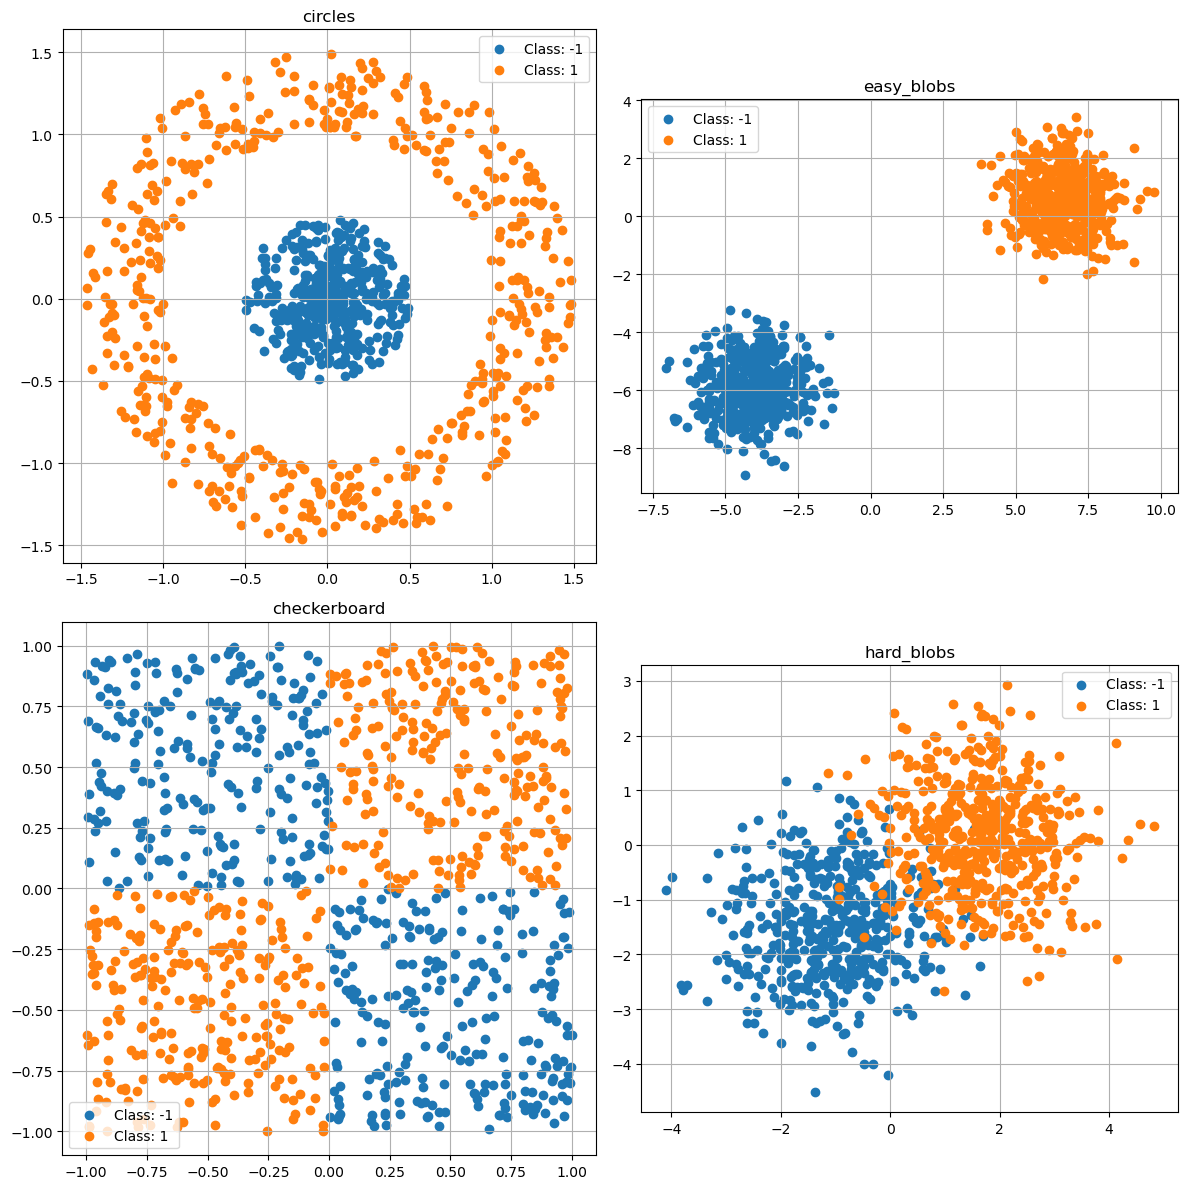

In [11]:
def plot_dataset(dataset, ax=None, title=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    classes = np.unique(dataset.labels)
    classes = np.sort(classes)
    for c in classes:
        ax.scatter(
            dataset.features[dataset.labels == c, 0],
            dataset.features[dataset.labels == c, 1],
            label=f'Class: {c}',
        )
    ax.set_aspect('equal')
    if title is not None:
        ax.set_title(title)
    ax.legend()

# Create the subplots
figure, axes = plt.subplots(2, 2, figsize=(12, 12))

# Plot each dataset
plot_dataset(circles, ax=axes[0, 0], title='circles')
plot_dataset(easy_blobs, ax=axes[0, 1], title='easy_blobs')
plot_dataset(checkerboard, ax=axes[1, 0], title='checkerboard')
plot_dataset(hard_blobs, ax=axes[1, 1], title='hard_blobs')

# Add this line to display the plots
plt.tight_layout()
plt.show()

# Rosenblatt Perceptron

For a shorter notation, lets use the following abbreviations:
\begin{align}
\tilde{\mathbf{w}} &= \begin{pmatrix}\mathbf w \\ w_0\end{pmatrix}, &
\tilde{\mathbf{x}}_n &= \begin{pmatrix}\mathbf x_n \\ 1\end{pmatrix}
\end{align}

Apply the Rosenblatt criterion to each of the datasets:
\begin{align}
J(\tilde{\mathbf{w}}) &= -\frac 1 N \sum_{n=1}^N \left(\frac{c_n - \hat c_n}{2}\right) \tilde{\mathbf{w}}^{\mathsf T} \tilde{\mathbf{x}}_n
\end{align}

Make sure to use some stopping criterion to avoid infinite loops. Plot the training loss over iterations. For which of the datasets does the training converge?

In [12]:
def add_augmentation(x):
    """
    Augments the input feature matrix by appending a column of ones to enable bias learning.

    This function adds a column of ones to the input feature matrix, which allows linear models
    to learn a bias term (intercept) during training. This is a common technique in machine learning
    to handle the bias term in a unified way with the weight vector.

    Parameters:
    -----------
    x : numpy.ndarray, shape (N, D)
        Input feature matrix where N is the number of samples and D is the number of features.

    Returns:
    --------
    numpy.ndarray, shape (N, D+1)
        Augmented feature matrix with an additional column of ones.

    Example:
    --------
    >>> x = np.array([[1, 2], [3, 4]])
    >>> add_augmentation(x)
    array([[1., 2., 1.],
           [3., 4., 1.]])
    """
    N = x.shape[0] 
    return np.concatenate([x, np.ones((N, 1))], axis=-1)

def remove_augmentation(x_tilde):
    """
    Removes the augmentation (bias term) from an augmented feature matrix.

    This function removes the last column (typically a column of ones) from an augmented
    feature matrix, effectively reversing the `add_augmentation` operation. It's useful
    when you need to work with the original features after performing operations on the
    augmented matrix.

    Parameters:
    -----------
    x_tilde : numpy.ndarray, shape (N, D+1)
        Augmented feature matrix where the last column is the augmentation (usually ones).

    Returns:
    --------
    numpy.ndarray, shape (N, D)
        Feature matrix with the augmentation column removed.

    Example:
    --------
    >>> x_augmented = np.array([[1., 2., 1.], [3., 4., 1.]])
    >>> remove_augmentation(x_augmented)
    array([[1., 2.],
           [3., 4.]])
    """
    return x_tilde[:, :-1]

In [13]:
def predict_rosenblatt_perceptron(x_tilde, w_tilde, transform_fn=None):
    """
    Predicts class labels using the Rosenblatt perceptron model.

    This function computes the discriminant values and class predictions for input
    data using a trained perceptron model. It supports optional feature transformation.

    Parameters:
    -----------
    x_tilde : numpy.ndarray, shape (n_samples, n_features + 1)
        Augmented feature matrix (including bias term).
    w_tilde : numpy.ndarray, shape (n_features + 1,)
        Augmented weight vector (including bias weight).
    transform_fn : callable, optional
        Function to transform features before prediction. If provided, the input
        features are first transformed and then augmented.

    Returns:
    --------
    discriminant : numpy.ndarray, shape (n_samples,)
        The raw output of the linear model (before thresholding).
    prediction : numpy.ndarray, shape (n_samples,)
        Predicted class labels (-1 or +1).

    Example:
    --------
    >>> x_tilde = np.array([[1, 2, 1], [3, 4, 1]])  # Augmented features
    >>> w_tilde = np.array([1, -1, 0])  # Weights including bias
    >>> disc, pred = predict_rosenblatt_perceptron(x_tilde, w_tilde)
    """
    if transform_fn is not None:
        x = remove_augmentation(x_tilde)
        x = transform_fn(x)
        x_tilde = add_augmentation(x)
    
    # Compute dot product between weights and features
    discriminant = np.einsum('d,nd->n', w_tilde, x_tilde)  
    # Convert to binary predictions (-1 or +1)
    prediction = map_0_1_to_minus_1_1(discriminant > 0) 
    return discriminant, prediction

In [14]:
def fit_rosenblatt_perceptron(dataset, iterations=1000, learning_rate=0.1, transform_fn=None):
    """
    Trains a Rosenblatt perceptron model on the given dataset.

    This function implements the perceptron learning algorithm with optional feature
    transformation. It updates the weights to minimize classification errors.

    Parameters:
    -----------
    dataset : object
        Dataset object containing:
        - features: numpy.ndarray of shape (n_samples, n_features)
        - labels: numpy.ndarray of shape (n_samples,) with values in {-1, 1}
    iterations : int, optional
        Maximum number of training iterations. Default is 1000.
    learning_rate : float, optional
        Step size for weight updates. Default is 0.1.
    transform_fn : callable, optional
        Function to transform features before training. If None, uses raw features.

    Returns:
    --------
    w_tilde : numpy.ndarray, shape (n_features + 1,)
        Learned weight vector including bias term.
    loss_history : numpy.ndarray, shape (iterations,)
        Training loss at each iteration.

    Notes:
    ------
    - Implements the Rosenblatt perceptron update rule
    - Uses 0-1 loss for weight updates
    - Automatically adds a bias term to the features
    """
    loss_history = np.empty(iterations)
    loss_history[:] = np.nan
    N = dataset.features.shape[0]
    
    # Apply feature transformation if provided
    if transform_fn is None:
        x_tilde = add_augmentation(dataset.features)
    else:
        x = transform_fn(dataset.features)
        x_tilde = add_augmentation(x)
    
    # Initialize weights randomly
    w_tilde = np.random.normal(size=x_tilde.shape[-1])
    c = dataset.labels
    
    # Training loop
    for iteration in range(iterations):
        # Make predictions
        _, c_hat = predict_rosenblatt_perceptron(x_tilde, w_tilde)
        
        # Calculate loss (0-1 loss)
        loss_history[iteration] = -1 / N * np.einsum('n,d,nd->', (c - c_hat) / 2, w_tilde, x_tilde)
        
        # Update weights using perceptron learning rule
        w_tilde = w_tilde + learning_rate * 1 / N * np.einsum('n,nd->d', (c - c_hat) / 2, x_tilde)  
    
    return w_tilde, loss_history

In [17]:
def compute_complete_grid(xlim, ylim, steps):
    """
    Creates a 2D grid of points spanning the specified x and y ranges.

    This function generates a mesh grid of points that can be used for evaluating
    and visualizing decision boundaries or other 2D functions over a specified range.

    Parameters:
    -----------
    xlim : tuple of float
        The (min, max) range for the x-axis.
    ylim : tuple of float
        The (min, max) range for the y-axis.
    steps : int
        Number of points to generate in each dimension.

    Returns:
    --------
    x : ndarray, shape (steps, steps)
        X-coordinates of the grid points.
    y : ndarray, shape (steps, steps)
        Y-coordinates of the grid points.
    grid : ndarray, shape (steps, steps, 2)
        Stacked array containing (x,y) coordinates for each point in the grid.

    Example:
    --------
    >>> x, y, grid = compute_complete_grid((0, 1), (0, 1), 3)
    >>> x
    array([[0. , 0.5, 1. ],
           [0. , 0.5, 1. ],
           [0. , 0.5, 1. ]])
    >>> y
    array([[0. , 0. , 0. ],
           [0.5, 0.5, 0.5],
           [1. , 1. , 1. ]])
    """
    x, y = np.meshgrid(
        np.linspace(*xlim, steps),
        np.linspace(*ylim, steps),
    )
    return x, y, np.stack([x, y], axis=-1)

def fit_and_plot(dataset, title, transform_fn=None, fit_function=fit_rosenblatt_perceptron, **kwargs):
    """
    Trains a classifier and visualizes the results including the decision boundary.

    This function fits a model to the dataset and creates a 2x1 subplot showing:
    1. Training loss over iterations
    2. The dataset with the learned decision boundary

    Parameters:
    -----------
    dataset : object
        Dataset object containing:
        - features: numpy.ndarray of shape (n_samples, n_features)
        - labels: numpy.ndarray of shape (n_samples,) with values in {-1, 1}
    title : str
        Title for the plot.
    transform_fn : callable, optional
        Function to transform features before training/prediction.
    fit_function : callable, optional
        Function to use for model fitting. Default is fit_rosenblatt_perceptron.
    **kwargs : dict
        Additional arguments to pass to the fit_function.

    Returns:
    --------
    None
        Displays a matplotlib figure with the training loss and decision boundary.

    Example:
    --------
    >>> fit_and_plot(dataset, "Linear Perceptron", learning_rate=0.1)
    """
    # Fit the model
    w_tilde, loss_history = fit_function(
        dataset,
        transform_fn=transform_fn,
        **kwargs,
    )
    
    # Create figure and plot loss
    _, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].plot(loss_history)
    axes[0].set_title('{}, final loss: {:.4f}'.format(title, loss_history[-1]))
    axes[0].set_yscale("symlog", linthresh=1e-5)
    
    # Plot dataset
    plot_dataset(dataset, ax=axes[1], title=title)
    
    # Generate grid for decision boundary
    steps = 100
    x, y, features_grid = compute_complete_grid(
        (np.min(dataset.features[:, 0]), np.max(dataset.features[:, 0])),
        (np.min(dataset.features[:, 1]), np.max(dataset.features[:, 1])),
        steps=steps
    )
    
    # Predict on grid points
    features_grid = features_grid.reshape(steps * steps, 2)
    features_grid = add_augmentation(features_grid)
    z, _ = predict_rosenblatt_perceptron(features_grid, w_tilde, transform_fn=transform_fn)
    z = np.reshape(z, (steps, steps))
    
    # Plot decision boundary
    if np.any(z < 0) and np.any(z > 0):
        axes[1].contour(x, y, z, levels=[0], colors='red')
    else:
        axes[1].contour(x, y, z, colors='red')
    
    plt.tight_layout()
    plt.show()
    
    print('Learned weights (including bias as last element):', w_tilde)

- Which datasets are linearly separable?
- Explain the loss curve for the non linearly separable datasets.
- Is the loss curve an indicator if the we can get a reasonable discriminant for non linearly separable datasets?

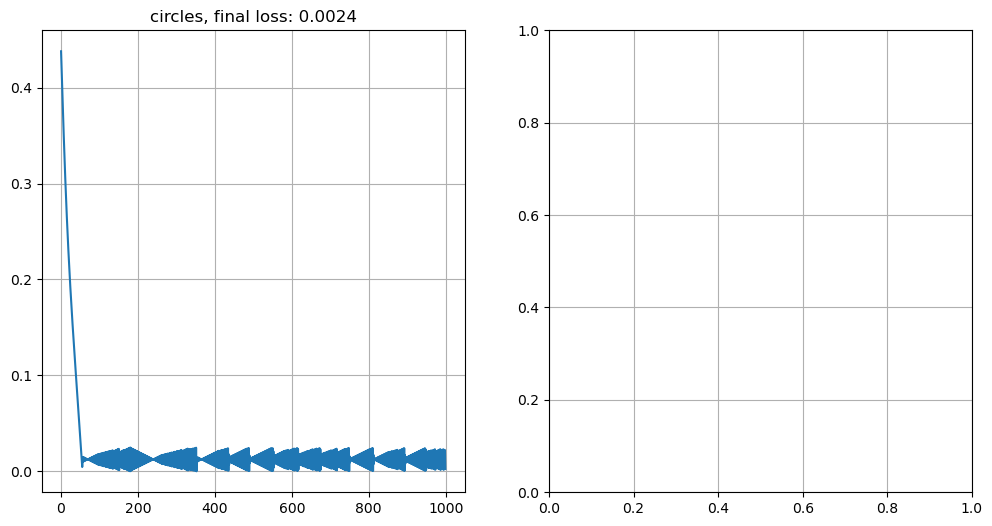

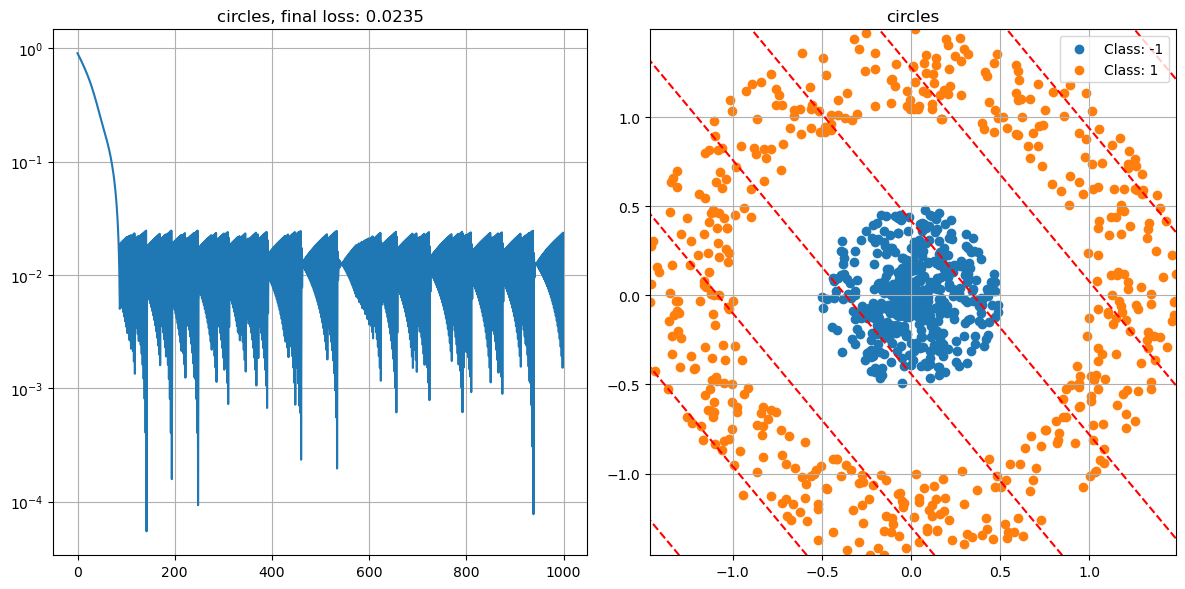

Learned weights (including bias as last element): [-0.00055848 -0.00046551 -0.00220551]


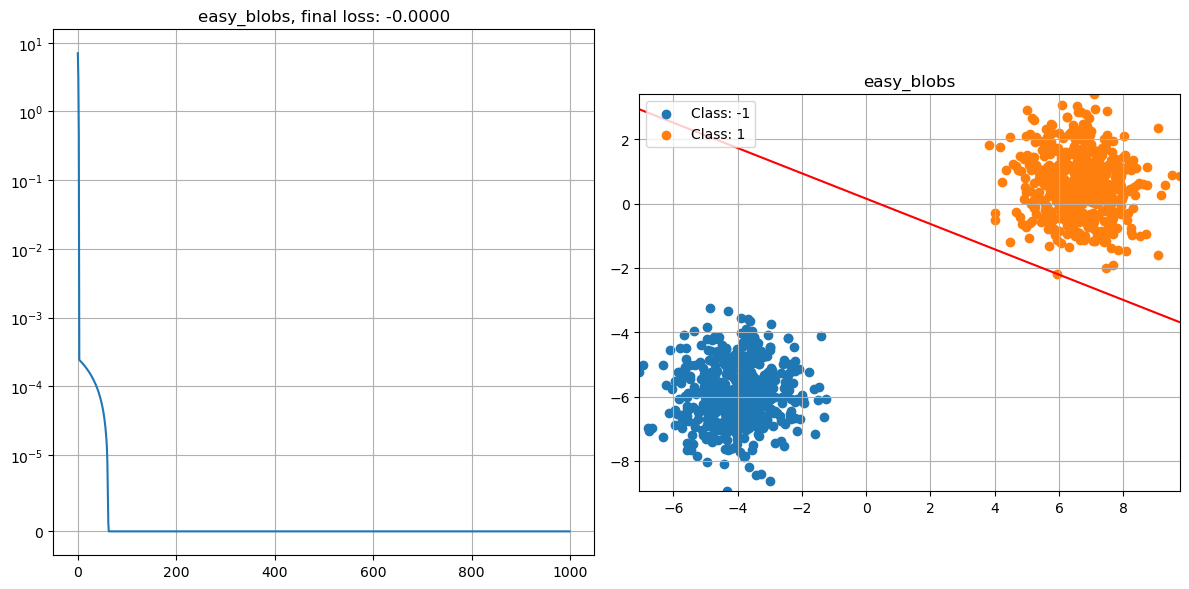

Learned weights (including bias as last element): [ 0.19388678  0.49211009 -0.076174  ]


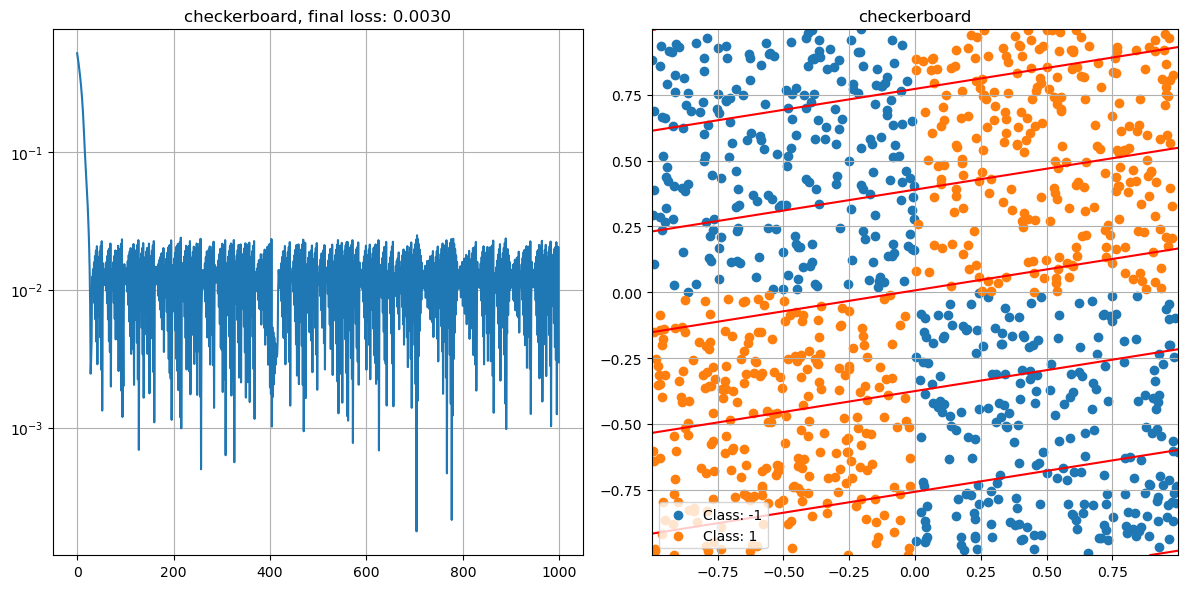

Learned weights (including bias as last element): [-0.00083114  0.00522741  0.04596319]


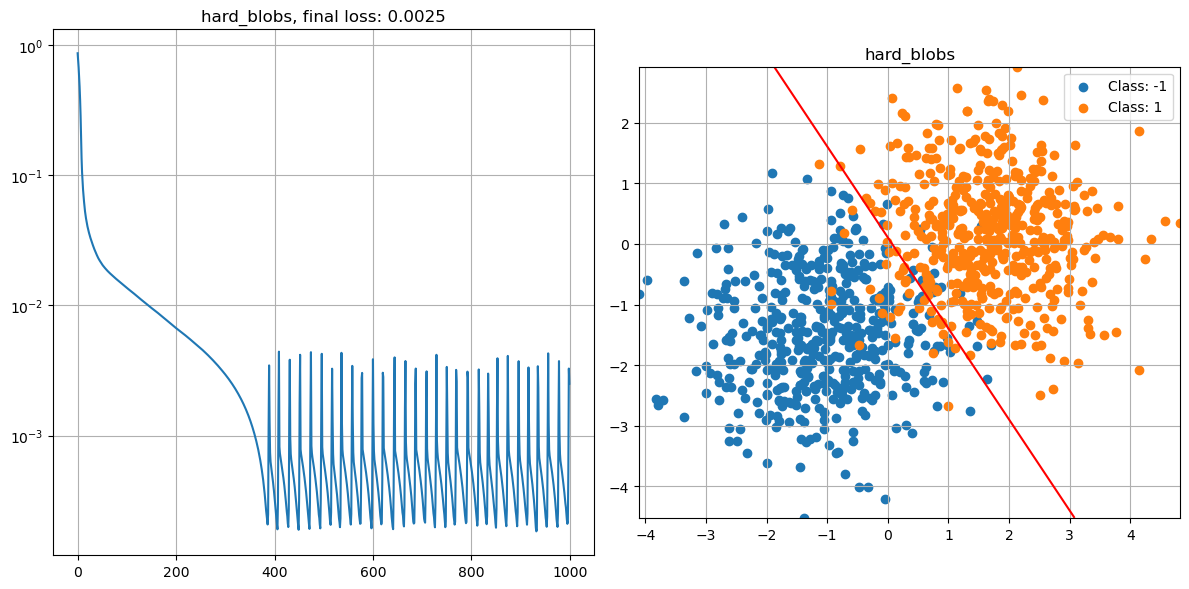

Learned weights (including bias as last element): [ 0.0347111   0.02311449 -0.00247595]


In [18]:
fit_and_plot(circles, 'circles')
fit_and_plot(easy_blobs, 'easy_blobs')
fit_and_plot(checkerboard, 'checkerboard')
fit_and_plot(hard_blobs, 'hard_blobs')

# Feature transformation

Which hand-crafted feature transformation is necessary to render the `circles` and `checkerboard` datasets linearly separable? Train a Rosenblatt perceptron using this transformation. Plot the trainig loss over iterations.

- Analyse the decision boundarys.
- Which solution generalizes better?
- For which dataset do you expect a better solution from SVM?

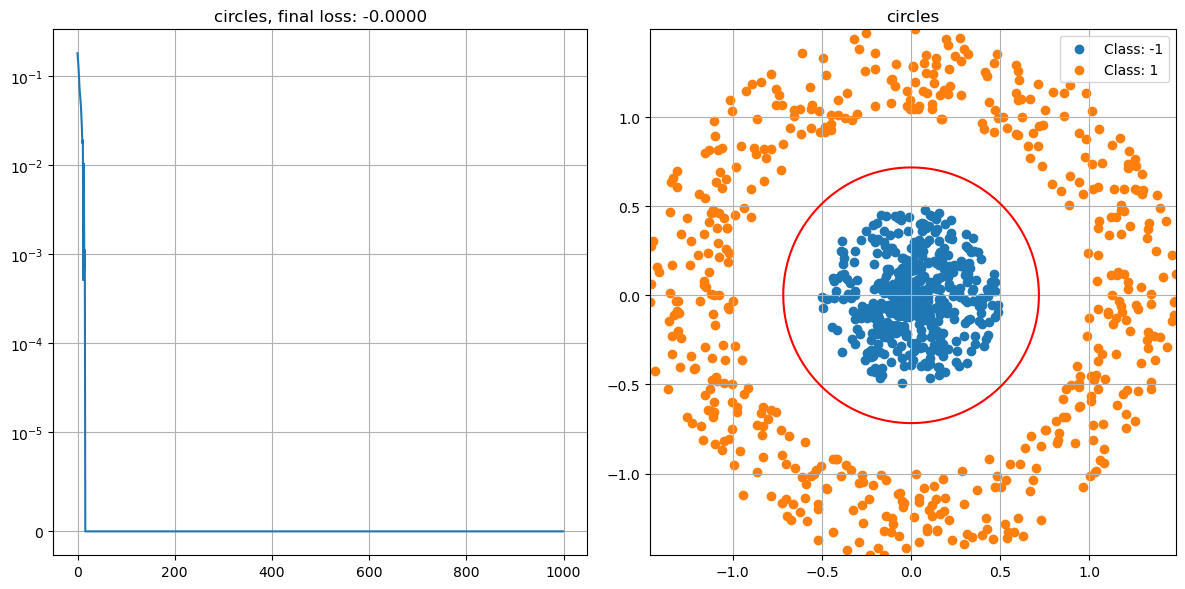

Learned weights (including bias as last element): [ 0.05030265 -0.03607559]


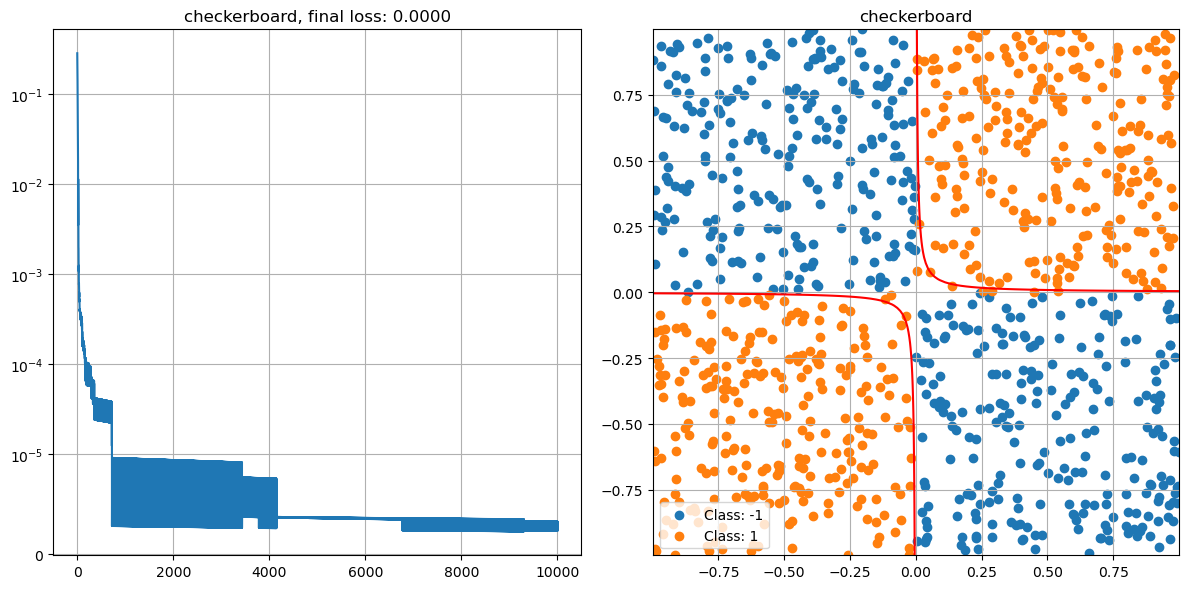

Learned weights (including bias as last element): [ 0.15253247 -0.00063892]


In [19]:
fit_and_plot(
    circles,
    'circles',
    transform_fn=lambda x: np.linalg.norm(x, axis=-1, keepdims=True),
)
fit_and_plot(
    checkerboard,
    'checkerboard',
    iterations=10000,
    transform_fn=lambda x: np.prod(x, axis=-1, keepdims=True), 
)

# Support vector machine

Train an SVM using gradient descent. For which datasets does the algorithm converge?

\begin{align}
	\tilde{\mathcal{L}}(\mathbf{w},w_0) = \frac{\|\mathbf{w}\|^2}{2} + \frac C N \sum_{n=1}^N \max\left(0, 1 - c_n(\mathbf{w}^{\mathsf T}\mathbf{x}_n+w_0) \right).
\end{align}


Text from SML script to this equation (Eq. 4.36):

> The first term will push the model to have a small weight vector $\mathbf w$, leading to a large
margin, while the second term computes the total of all margin violations. Minimizing
this term ensures that the model makes the margin violations as small and as few as
possible. $C$ is a trade-off parameter between the two contributions to the cost function.
This objective function can be minimized by gradient descent.
>
> By the way, the function max(0, 1−x) is the hinge loss we have seen earlier in Section 2.7.3

Apply the same feature transform as before to render the `circles` and `checkerboard` dataset linearly separable.



The gradients are:
\begin{align}
\frac{\partial J}{\partial \mathbf w} &= \mathbf w + \frac C N \sum_{n=1}^N -c_n \mathrm{heaviside}\bigg(1 - c_n(\mathbf{w}^{\mathsf T}\mathbf{x}_n+w_0)\bigg) \mathbf x_n \\
\frac{\partial J}{\partial w_0} &= \frac C N \sum_{n=1}^N -c_n \mathrm{heaviside}\bigg(1 - c_n(\mathbf{w}^{\mathsf T}\mathbf{x}_n+w_0)\bigg)
\end{align}

In [ ]:
def fit_support_vector_machine(dataset, transform_fn=None, iterations=10000, learning_rate=0.01, hinge_loss_weight=10):
    loss_history = np.empty(iterations)
    loss_history[:] = np.nan
    N = dataset.features.shape[0]
    x_tilde = add_augmentation(dataset.features)
    
    if transform_fn is not None:
        x = remove_augmentation(x_tilde)
        x = transform_fn(x)
        x_tilde = add_augmentation(x)
    
    w_tilde = np.random.normal(size=x_tilde.shape[-1])
    c = dataset.labels
    for iteration in range(iterations):
        discriminant, c_hat = predict_rosenblatt_perceptron(x_tilde, w_tilde)
        z = 1 - c * discriminant
        loss_history[iteration] = np.linalg.norm(w_tilde[:-1]) / 2 + hinge_loss_weight * np.sum(np.maximum(0, z), axis=0)  # REPLACE loss_history[iteration] = ???
        gradient_w = w_tilde[:-1] + hinge_loss_weight / N * np.einsum('n,n,nd->d', np.heaviside(z, 0.5), -c, x_tilde[:, :-1])  # REPLACE gradient_w = ???
        gradient_w_0 = hinge_loss_weight / N * np.einsum('n,n->', np.heaviside(z, 0.5), -c)  # REPLACE gradient_w_0 = ???
        gradient = np.concatenate((gradient_w, [gradient_w_0]))
        w_tilde = w_tilde - learning_rate * gradient
    return w_tilde, loss_history

In [ ]:
fit_and_plot(easy_blobs, 'easy_blobs', fit_function=fit_support_vector_machine, hinge_loss_weight=1e4, learning_rate=0.001)
fit_and_plot(hard_blobs, 'hard_blobs', fit_function=fit_support_vector_machine)

In [ ]:
fit_and_plot(circles, 'circles', fit_function=fit_support_vector_machine, transform_fn=lambda x: np.linalg.norm(x, axis=-1, keepdims=True))
fit_and_plot(
    checkerboard, 'checkerboard',
    fit_function=fit_support_vector_machine,
    transform_fn=lambda x: np.prod(x, axis=-1, keepdims=True),  # REPLACE transform_fn=lambda x: ???,
    iterations=10000,  
    learning_rate=0.001,  
    hinge_loss_weight=100, 
)

In [ ]:
sign_dataset = Dataset(np.array([[1, 1], [-1, 1], [1, -1], [-1, -1]]) * 100, np.array([-1, -1, 1, 1]))
plot_dataset(sign_dataset)

- How should the decision boundary look like?
- Can you explain, why the SVM code does not work for this simple example?

In [ ]:
fit_and_plot(sign_dataset, 'sign', fit_function=fit_support_vector_machine)

In [ ]:
sign_dataset2 = Dataset(np.array([[1, 1], [-1, 1], [0, -1], [0, -1.5]]), np.array([-1, -1, 1, 1]))
plot_dataset(sign_dataset2)

- How should the decision boundary look like?
- Can you explain, why the decision boundary is not the expected one?

In [ ]:
fit_and_plot(sign_dataset2, 'sign2', fit_function=fit_support_vector_machine, hinge_loss_weight=1)

# For experts...

- The SVM parameters can be learned faster by using an appropriate solver instead of using gradient descent.
Check how the parameters are obtained in the `sklearn` source code and use it to verify your results.
- Mark the support vectors in your diagrams.
- What is the advantage of training the SVM with gradient descent?